Epoch [20/1000], Loss: 0.3895
Epoch [40/1000], Loss: 0.1731
Epoch [60/1000], Loss: 0.3108
Epoch [80/1000], Loss: 0.2076
Epoch [100/1000], Loss: 0.2363
Epoch [120/1000], Loss: 0.3480
Epoch [140/1000], Loss: 0.2237
Epoch [160/1000], Loss: 0.3811
Epoch [180/1000], Loss: 0.2639
Epoch [200/1000], Loss: 0.2270
Epoch [220/1000], Loss: 0.3111
Epoch [240/1000], Loss: 0.2465
Epoch [260/1000], Loss: 0.1407
Epoch [280/1000], Loss: 0.1958
Epoch [300/1000], Loss: 0.1089
Epoch [320/1000], Loss: 0.1644
Epoch [340/1000], Loss: 0.1327
Epoch [360/1000], Loss: 0.0602
Epoch [380/1000], Loss: 0.0733
Epoch [400/1000], Loss: 0.0961
Epoch [420/1000], Loss: 0.0826
Epoch [440/1000], Loss: 0.0351
Epoch [460/1000], Loss: 0.0263
Epoch [480/1000], Loss: 0.0826
Epoch [500/1000], Loss: 0.0215
Epoch [520/1000], Loss: 0.0157
Epoch [540/1000], Loss: 0.0141
Epoch [560/1000], Loss: 0.0120
Epoch [580/1000], Loss: 0.0044
Epoch [600/1000], Loss: 0.0056
Epoch [620/1000], Loss: 0.0015
Epoch [640/1000], Loss: 0.0114
Epoch [660/1

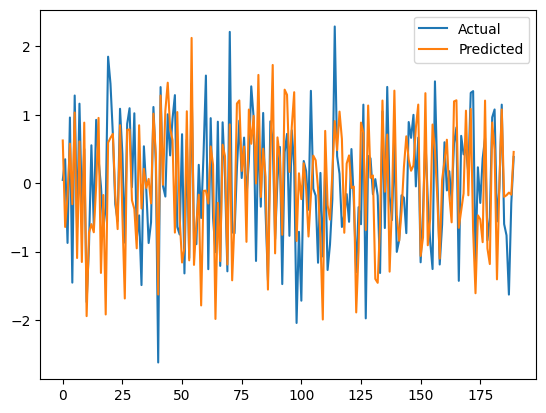

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 設置超參數
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
num_epochs = 1000
learning_rate = 0.001

# 生成合成數據
def generate_data(seq_length, num_samples):
    x = np.linspace(0, 100, num_samples)
    y = np.sin(x) + 0.5 * np.random.randn(num_samples)
    data = []
    for i in range(len(y) - seq_length):
        data.append((y[i:i+seq_length], y[i+seq_length]))
    return data

seq_length = 10
num_samples = 1000
data = generate_data(seq_length, num_samples)

# 構建LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 訓練數據和測試數據
train_data = data[:800]
test_data = data[800:]

# 創建數據加載器
def create_dataloader(data, batch_size):
    sequences, labels = zip(*data)
    sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(-1)
    dataset = torch.utils.data.TensorDataset(sequences, labels)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 32
train_loader = create_dataloader(train_data, batch_size)
test_loader = create_dataloader(test_data, batch_size)

# 設置設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型、損失函數和優化器
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 測試模型
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        predictions.append(outputs.cpu().numpy())
        actuals.append(labels.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# 繪製結果
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()
